# Divvy 2016

From the officially released data: 

> - **trip_id**: ID attached to each trip taken
- **starttime**: day and time trip started, in CST
- **stoptime**: day and time trip ended, in CST
- **bikeid**: ID attached to each bike
- **tripduration**: time of trip in seconds 
- **from_station_name**: name of station where trip originated
- **to_station_name**: name of station where trip terminated 
- **from_station_id**: ID of station where trip originated
- **to_station_id**: ID of station where trip terminated
- **gender**: gender of rider 
- **birthyear**: birth year of rider
- **usertype**:
1. **Customer**: rider who purchased a 24-Hour Pass;<br>
2. **Subscriber**: rider who purchased an Annual Membership



> Notes:
* First row contains column names
* Trips that did not include a start or end date were removed from original table.
* Gender and birthday are only available for Subscribers

> For more information, visit http://DivvyBikes.com/data or email questions to data@DivvyBikes.com. 

### Basic Jupyter Notebook data

In [1]:
%reload_ext watermark
%watermark -a 'Author: James Larkin' 
print ''
%watermark -u -n -t -z
print ''
%watermark -g

Author: James Larkin

last updated: Sat Mar 25 2017 04:06:51 EDT

Git hash: 377bfe3e2a3592659d987aaa53caa6439facddf5


### Load libraries and modules

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from scipy import stats
from __future__ import division
from datetime import datetime, timedelta
from dateutil import relativedelta
import folium
import glob
from IPython.display import Image
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Read in data for analysis

In [4]:
filenames = glob.glob('Divvy_data/Divvy_Trips*.csv')

In [5]:
divvy_sets = []
for file in filenames:
    print('Reading in {0}'.format(file))
    divvy_sets.append(pd.read_csv(file,
                                  parse_dates=['starttime', 'stoptime'], 
                                  infer_datetime_format=True))

Reading in Divvy_data/Divvy_Trips_2016_Q1.csv
Reading in Divvy_data/Divvy_Trips_2016_Q2_04.csv
Reading in Divvy_data/Divvy_Trips_2016_Q2_05.csv
Reading in Divvy_data/Divvy_Trips_2016_Q2_06.csv
Reading in Divvy_data/Divvy_Trips_2016_Q3.csv
Reading in Divvy_data/Divvy_Trips_2016_Q4.csv


In [6]:
!wc -l Divvy_data/Divvy_Trips*.csv

  396914 Divvy_data/Divvy_Trips_2016_Q1.csv
  231636 Divvy_data/Divvy_Trips_2016_Q2_04.csv
  363320 Divvy_data/Divvy_Trips_2016_Q2_05.csv
  477874 Divvy_data/Divvy_Trips_2016_Q2_06.csv
 1441812 Divvy_data/Divvy_Trips_2016_Q3.csv
  683833 Divvy_data/Divvy_Trips_2016_Q4.csv
 3595389 total


In [7]:
#shebang rm in bash to remove .csv 
!rm *.csv

rm: *.csv: No such file or directory


In [8]:
divvy = pd.concat(divvy_sets)

### Pickle the 2016 Divvy data

In [9]:
divvy.to_pickle('divvy.pkl')

In [10]:
divvy = pd.read_pickle('divvy.pkl')

### High level overview of the dataset

In [11]:
divvy.shape

(3595383, 12)

In [12]:
divvy.info()
#divvy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3595383 entries, 0 to 683831
Data columns (total 12 columns):
trip_id              int64
starttime            datetime64[ns]
stoptime             datetime64[ns]
bikeid               int64
tripduration         int64
from_station_id      int64
from_station_name    object
to_station_id        int64
to_station_name      object
usertype             object
gender               object
birthyear            float64
dtypes: datetime64[ns](2), float64(1), int64(5), object(4)
memory usage: 356.6+ MB


In [13]:
divvy.dtypes.value_counts()

int64             5
object            4
datetime64[ns]    2
float64           1
dtype: int64

In [14]:
#Memory usage does not include memory consumed by elements
# that are not components of the array if deep=False
print('Total bytes: {0} and Total MB: {1}\n'
      .format(divvy.memory_usage(deep=True).sum(),
              int(divvy.memory_usage(deep=True).sum()/1048576)))
print(divvy.memory_usage(deep=True))

Total bytes: 1110073825 and Total MB: 1058

Index                 28763064
trip_id               28763064
starttime             28763064
stoptime              28763064
bikeid                28763064
tripduration          28763064
from_station_id       28763064
from_station_name    246106256
to_station_id         28763064
to_station_name      246110882
usertype             196029077
gender               162960034
birthyear             28763064
dtype: int64


In [15]:
divvy._data

BlockManager
Items: Index([u'trip_id', u'starttime', u'stoptime', u'bikeid', u'tripduration',
       u'from_station_id', u'from_station_name', u'to_station_id',
       u'to_station_name', u'usertype', u'gender', u'birthyear'],
      dtype='object')
Axis 1: Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            683822, 683823, 683824, 683825, 683826, 683827, 683828, 683829,
            683830, 683831],
           dtype='int64', length=3595383)
DatetimeBlock: slice(1, 3, 1), 2 x 3595383, dtype: datetime64[ns]
FloatBlock: slice(11, 12, 1), 1 x 3595383, dtype: float64
IntBlock: [0, 3, 4, 5, 7], 5 x 3595383, dtype: int64
ObjectBlock: [6, 8, 9, 10], 4 x 3595383, dtype: object

In [16]:
objects = divvy.select_dtypes(['object'])
objects_memory = objects.memory_usage(deep=True)
obj_memory_total = (objects_memory.sum()/1048576)
print('True MB used to store the strings in the object columns is roughly {0} MB.'
      .format(int(obj_memory_total)))

True MB used to store the strings in the object columns is roughly 839 MB.


**Since many of these object strings are actually numbers, may wish to review dtype changes to reduce memory usage and potentially increase performance should code blocks lag.**

In [17]:
divvy.shape

(3595383, 12)

In [18]:
divvy.head(2)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,9080551,2016-03-31 23:53:00,2016-04-01 00:07:00,155,841,344,Ravenswood Ave & Lawrence Ave,458,Broadway & Thorndale Ave,Subscriber,Male,1986.0
1,9080550,2016-03-31 23:46:00,2016-03-31 23:57:00,4831,649,128,Damen Ave & Chicago Ave,213,Leavitt St & North Ave,Subscriber,Male,1980.0


In [19]:
divvy.columns

Index([u'trip_id', u'starttime', u'stoptime', u'bikeid', u'tripduration',
       u'from_station_id', u'from_station_name', u'to_station_id',
       u'to_station_name', u'usertype', u'gender', u'birthyear'],
      dtype='object')

### Rename columns for readability

In [20]:
divvy = pd.read_pickle('divvy.pkl')

In [21]:
divvy = divvy.rename(columns={'starttime':'start_time', 'stoptime':'stop_time',
                              'bikeid':'bike_id', 'tripduration':'trip_duration',
                              'from_station_id':'start_id',
                              'from_station_name': 'start_station',
                              'to_station_id':'end_id',
                              'to_station_name': 'end_station',
                              'usertype':'user_type', 'birthyear':'birth_year'})

### Check if there are any nulls in the dataset

In [22]:
complete = divvy.notnull().sum() * 100.0/divvy.shape[0]
print("Percentage complete for each column: \n{0}".format(complete))

Percentage complete for each column: 
trip_id          100.000000
start_time       100.000000
stop_time        100.000000
bike_id          100.000000
trip_duration    100.000000
start_id         100.000000
start_station    100.000000
end_id           100.000000
end_station      100.000000
user_type        100.000000
gender            76.124129
birth_year        76.132584
dtype: float64


In [23]:
divvy.apply(lambda x: sum(x.isnull()), axis=0)

trip_id               0
start_time            0
stop_time             0
bike_id               0
trip_duration         0
start_id              0
start_station         0
end_id                0
end_station           0
user_type             0
gender           858429
birth_year       858125
dtype: int64

### User type breakout

In [24]:
a = pd.DataFrame(divvy.user_type.value_counts().sort_values(ascending=False))
b = pd.DataFrame(divvy.user_type.value_counts()/divvy.user_type.value_counts().sum())
b = b*100; b = b.rename(columns={'user_type':'% of total'})
user_type = pd.concat([a, b], axis=1); print(user_type)
print('Total         {0}'.format(divvy.user_type.value_counts().sum()))

            user_type  % of total
Subscriber    2736869   76.121765
Customer       858474   23.877122
Dependent          40    0.001113
Total         3595383


In [25]:
b['% of total'] = b.sum(axis=1)
new_index= ['Subscriber', 'Customer', 'Dependent', 'Total']
b = b.reindex(new_index, fill_value=100.00)
b['% of total'] = b['% of total'].round(2); print(b)

            % of total
Subscriber       76.12
Customer         23.88
Dependent         0.00
Total           100.00


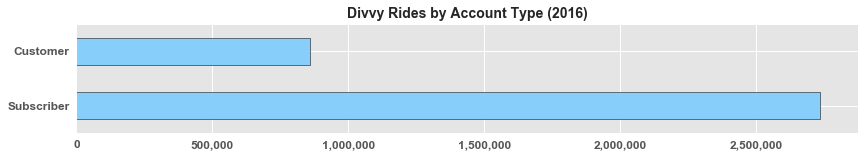

In [26]:
fig = plt.figure(figsize=(14, 2))
ax = fig.gca() #.invert_yaxis()
colors = ['#87CEFA']
divvy.user_type.value_counts(ascending=False).head(2).plot(kind='barh',
                                               color=colors,
                                               edgecolor="#000000")
plt.xticks([0, 500000, 1000000, 1500000, 2000000, 2500000],
           ['0', '500,000', '1,000,000', '1,500,000',
            '2,000,000', '2,500,000'],
           fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Divvy Rides by Account Type (2016)", fontsize=14, fontweight='bold');

### User type breakout by gender

**Only subscriber's gender and year of birth are collected. Hence, null values for the customers in the dataset.**

In [27]:
c = pd.DataFrame(divvy.gender.value_counts().sort_values(ascending=False))
d = pd.DataFrame(divvy.gender.value_counts()/divvy.gender.value_counts().sum())
d = d*100; d = d.rename(columns={'gender':'% of total'})
#d['% of total'] = d['% of total'].round(2)
member_gender = pd.concat([c, d], axis=1); print(member_gender)
print('Total   {0}'.format(divvy.gender.value_counts().sum()))

         gender  % of total
Male    2047174    74.79753
Female   689780    25.20247
Total   2736954


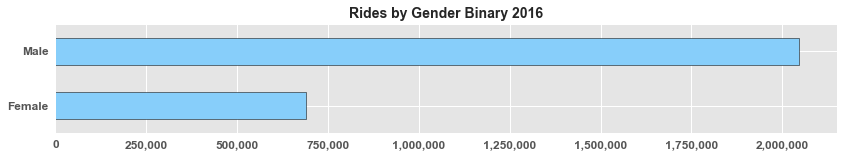

In [28]:
fig = plt.figure(figsize=(14, 2))
ax = fig.gca() #.invert_yaxis()
colors = ['#87CEFA']
divvy.gender.value_counts(ascending=True).plot(kind='barh',
                                               color=colors,
                                               edgecolor="#000000")
plt.xticks([0, 250000, 500000, 750000, 1000000,
            1250000, 1500000, 1750000, 2000000],
           ['0', '250,000', '500,000', '750,000','1,000,000',
            '1,250,000', '1,500,000', '1,750,000', '2,000,000'],
           fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Rides by Gender Binary 2016", fontsize=14, fontweight='bold');

In [29]:
millennials = divvy[(divvy.birth_year >= 1981) & (divvy.birth_year <= 1994)]

In [30]:
millennials.gender.value_counts()

Male      1188649
Female     464362
Name: gender, dtype: int64

In [31]:
millennials.gender.value_counts()/millennials.gender.value_counts().sum() * 100

Male      71.908112
Female    28.091888
Name: gender, dtype: float64

In [32]:
genX_split = divvy[(divvy.birth_year >= 1965) & (divvy.birth_year <= 1980)]

In [33]:
genX_split.gender.value_counts()

Male      590487
Female    145932
Name: gender, dtype: int64

In [34]:
genX_split.gender.value_counts()/genX_split.gender.value_counts().sum() * 100

Male      80.183564
Female    19.816436
Name: gender, dtype: float64

### Member birth year

In [35]:
divvy.birth_year.fillna(0, inplace=True)
divvy.birth_year = divvy.birth_year.astype(int)

**Formerly the null values (mainly customers in which
birth year data is not, nor likely could be, collected).
Set to zero for now so as to more easily visualize the birth
year data in bar chart form.**

In [36]:
divvy.birth_year.value_counts()[0]

858125

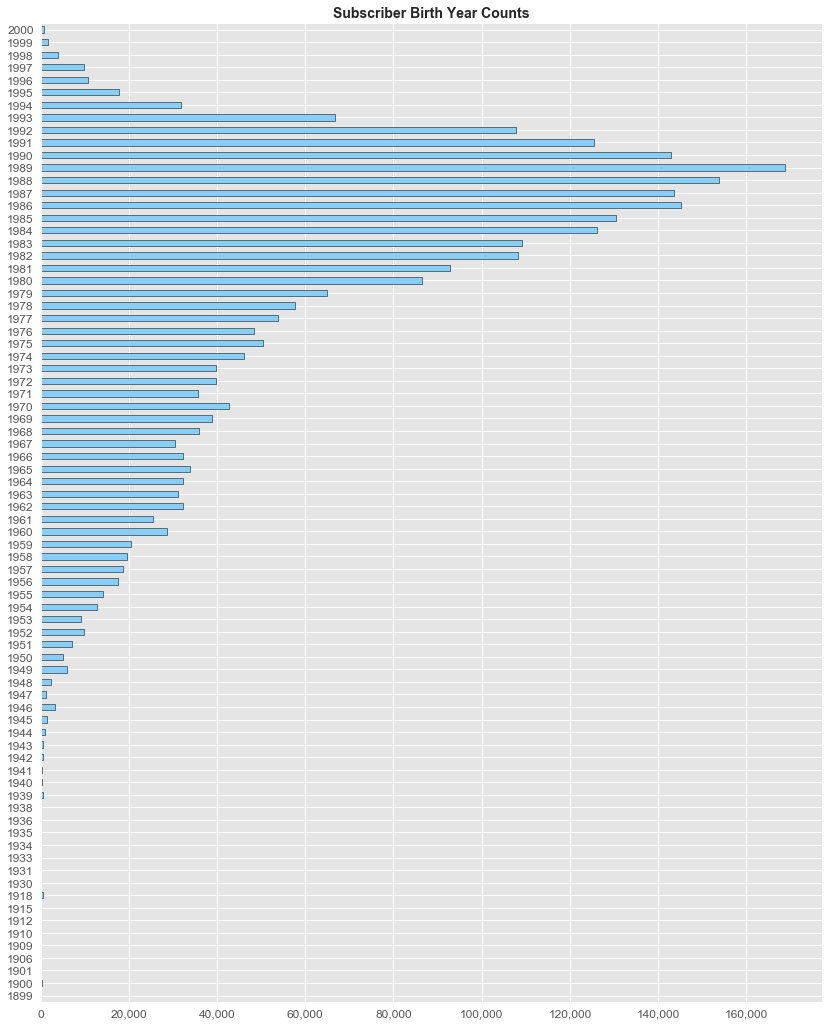

In [37]:
#Baby Boomers 1946-1964, Generation X 1965-1980,
#Generation Y 1981-1994, Generation Z 1995-2016
fig = plt.figure(figsize=(14, 18))
ax = fig.gca()
colors = ['#87CEFA']
divvy.birth_year.value_counts().sort_index()[1:].plot(kind='barh',
                                               color=colors,
                                               edgecolor="#000000")
plt.xticks([0, 20000, 40000, 60000, 80000,
            100000, 120000, 140000, 160000],
           ['0', '20,000', '40,000', '60,000','80,000',
            '100,000', '120,000', '140,000', '160,000'],
           fontsize=12)
plt.yticks(fontsize=12)
plt.title("Subscriber Birth Year Counts", fontsize=14, fontweight='bold');

In [38]:
#Baby Boomers 1946-1964, Generation X 1965-1980,
#Generation Y 1981-1994, Generation Z 1995-2016
pre_boom = divvy.birth_year.value_counts().sort_index()[0:24].sum()
print('Subscriber count for prior gens:   {0}'.format(pre_boom))
boomers = divvy.birth_year.value_counts().sort_index()[24:43].sum()
print('Subscriber count for Baby Boomers: {0}'.format(boomers))
gen_x = divvy.birth_year.value_counts().sort_index()[43:59].sum()
print('Subscriber count for Generation X: {0}'.format(gen_x))
gen_y = divvy.birth_year.value_counts().sort_index()[59:73].sum()
print('Subscriber count for Millennials: {0}'.format(gen_y))
gen_z = divvy.birth_year.value_counts().sort_index()[73:].sum()
print('Subscriber count for Generation Z:  {0}'.format(gen_z))

Subscriber count for prior gens:   864295
Subscriber count for Baby Boomers: 296714
Subscriber count for Generation X: 736727
Subscriber count for Millennials: 1653011
Subscriber count for Generation Z:  44636


In [39]:
pre = (pre_boom/divvy.birth_year.count())*100; pre = round(pre,2)
b = (boomers/divvy.birth_year.count())*100; b = round(b,2)
x = (gen_x/divvy.birth_year.count())*100; x = round(x,2)
y = (gen_y/divvy.birth_year.count())*100; y = round(y,2)
z = (gen_z/divvy.birth_year.count())*100; z = round(z,2)
print('Percentage of Subscribers by generation: \n\nPre-boomers: {0}%, \
Boomers: {1}%, Gen-X: {2}%, Millennials: {3}%, Gen-Z: {4}%'.format(pre, b, x, y, z))

Percentage of Subscribers by generation: 

Pre-boomers: 24.04%, Boomers: 8.25%, Gen-X: 20.49%, Millennials: 45.98%, Gen-Z: 1.24%


In [40]:
print(member_gender)

         gender  % of total
Male    2047174    74.79753
Female   689780    25.20247


**As is common in the world of bike share, subscribers are predominantly male and/or fall into the 
Millennial/Gen-X category.**

**Also, considering the range of the birth years and the fairly large percentage of perceived pre-boomers/silent generation riders, it's safe to assume that some subscribers have not been honest about their actual birth year. Outliers such as 1900 and 1918 are suspect.**

### Trip Duration (time of trip in seconds)

**Customers: 24-Hour Pass = 9.95/day - unlimited 30-minute rides in a 24-hour period**<br>
**Subscriber: 99 dollars/year = unlimited 30-minute rides for 365 days**

In [41]:
divvy.head(2)

,trip_id,start_time,stop_time,bike_id,trip_duration,start_id,start_station,end_id,end_station,user_type,gender,birth_year
0,9080551,2016-03-31 23:53:00,2016-04-01 00:07:00,155,841,344,Ravenswood Ave & Lawrence Ave,458,Broadway & Thorndale Ave,Subscriber,Male,1986
1,9080550,2016-03-31 23:46:00,2016-03-31 23:57:00,4831,649,128,Damen Ave & Chicago Ave,213,Leavitt St & North Ave,Subscriber,Male,1980


In [42]:
print('Average Divvy trip in seconds: {0}'.format(divvy.trip_duration.mean()))

Average Divvy trip in seconds: 993.343018532


In [43]:
# CODE CREDIT: http://stackoverflow.com/questions/11882393/
# matplotlib-disregard-outliers-when-plotting
# http://stackoverflow.com/users/325565/joe-kington
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

BE ADVISED: Scales are significantly different.


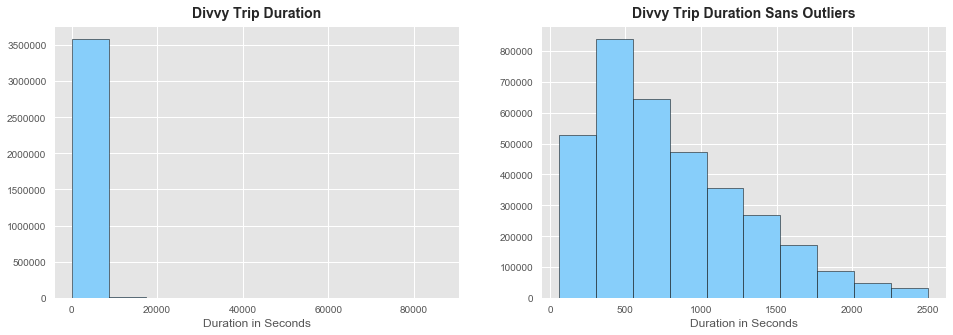

In [44]:
print('BE ADVISED: Scales are significantly different.')
x = divvy.trip_duration
filtered = x[~is_outlier(x)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.hist(x, color='#87CEFA', edgecolor="#000000")
ax1.set_title('Divvy Trip Duration', y=1.01,
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Duration in Seconds')
ax2.hist(filtered, color='#87CEFA', edgecolor="#000000")
ax2.set_title('Divvy Trip Duration Sans Outliers', y=1.01,
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Duration in Seconds')
plt.show()

In [45]:
#seconds to minutes
divvy.trip_duration /= 60

In [46]:
print('Average Divvy trip in minutes: {0}'.format(divvy.trip_duration.mean()))

Average Divvy trip in minutes: 16.5557169755


In [47]:
divvy.head(2)

,trip_id,start_time,stop_time,bike_id,trip_duration,start_id,start_station,end_id,end_station,user_type,gender,birth_year
0,9080551,2016-03-31 23:53:00,2016-04-01 00:07:00,155,14.016667,344,Ravenswood Ave & Lawrence Ave,458,Broadway & Thorndale Ave,Subscriber,Male,1986
1,9080550,2016-03-31 23:46:00,2016-03-31 23:57:00,4831,10.816667,128,Damen Ave & Chicago Ave,213,Leavitt St & North Ave,Subscriber,Male,1980


BE ADVISED: Scales are significantly different.


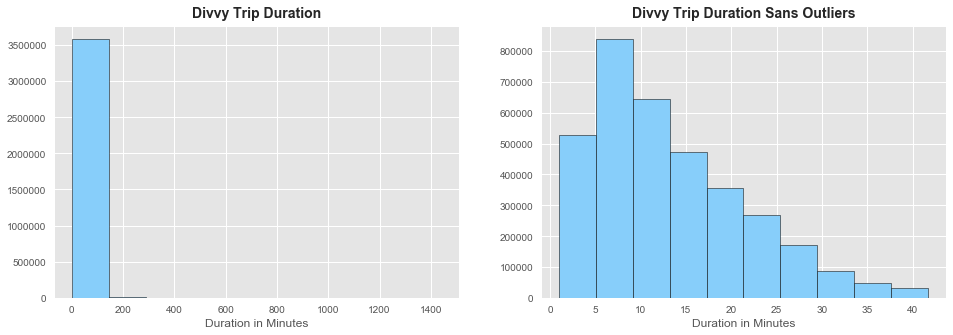

In [48]:
print('BE ADVISED: Scales are significantly different.')
x = divvy.trip_duration
filtered = x[~is_outlier(x)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.hist(x, color='#87CEFA', edgecolor="#000000")
ax1.set_title('Divvy Trip Duration', y=1.01,
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Duration in Minutes')
ax2.hist(filtered, color='#87CEFA', edgecolor="#000000")
ax2.set_title('Divvy Trip Duration Sans Outliers', y=1.01,
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Duration in Minutes')
plt.show()

In [49]:
print("Maximum Trip Duration: {0:,.0f}"
      .format(stats.scoreatpercentile(divvy.trip_duration, 100)))
print("Trip Duration 99th percentile: {0:,.0f}"
      .format(stats.scoreatpercentile(divvy.trip_duration, 99)))

Maximum Trip Duration: 1,439
Trip Duration 99th percentile: 91


In [50]:
divvy.trip_duration.quantile(0.995)

127.81666666666666

In [51]:
treks = divvy[divvy.trip_duration > 128]; len(treks)

17934

In [52]:
len(treks)/len(divvy) * 100

0.49880638585652765

**A mere 0.5% of the trip duration data falls just a shade over two hours of ride time.**<br>
<br>
**If modeling, may wish to devise a reasonable approach to removing extreme outliers from any training/test sets.**

### Find which day of the week rides take place

In [53]:
ind = pd.DatetimeIndex(divvy.start_time)
divvy['date'] = ind.date.astype('datetime64')
divvy['month'] = ind.month
divvy['hour'] = ind.hour

In [54]:
#divvy['weekday'] = df.index.weekday
divvy.weekday = divvy.start_time.dt.dayofweek

In [55]:
divvy['day_of_week'] = pd.Series(divvy.weekday)

In [56]:
#The day of the week with Monday=0, Sunday=6
x = pd.DataFrame(divvy.weekday.value_counts().sort_values(ascending=False))
x = x.rename(columns={'start_time':'count'});
y = pd.DataFrame(divvy.weekday.value_counts()/divvy.weekday.value_counts().sum())
y = y*100; y = y.rename(columns={'start_time':'% of total'})
z = pd.DataFrame(y.sort_index().pct_change()*100)
z = z.rename(columns={'% of total':'pct change'});

In [57]:
days = {'day': ['Monday', 'Tuesday', 'Wednesday','Thursday',
                'Friday', 'Saturday','Sunday']}
days = pd.DataFrame(days, columns = days)

In [58]:
#The day of the week with Monday=0, Sunday=6
day_breakout = pd.concat([days, x, y, z], axis=1); print(day_breakout)
print
print('Total rides {0}\n'.format(divvy.weekday.value_counts().sum()))

         day   count  % of total  pct change
0     Monday  552181   15.358058         NaN
1    Tuesday  541710   15.066823   -1.896298
2  Wednesday  479760   13.343780  -11.436008
3   Thursday  502298   13.970640    4.697766
4     Friday  529283   14.721185    5.372309
5   Saturday  502176   13.967246   -5.121457
6     Sunday  487975   13.572268   -2.827893

Total rides 3595383



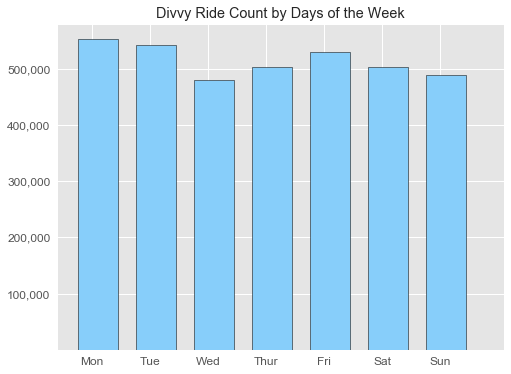

In [59]:
fig = plt.figure(figsize=(8, 6))
plt.gca()
plt.xticks([0, 1, 2, 3, 4, 5, 6], 
           ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.yticks([100000, 200000, 300000, 400000, 500000],
           ['100,000', '200,000', '300,000', '400,000',
            '500,000'], fontsize=12)
plt.hist(divvy.day_of_week, bins=np.arange(8)-0.25,
         width=0.70, color='#87CEFA', edgecolor='#000000')
plt.title("Divvy Ride Count by Days of the Week");

In [60]:
#The day of the week with Monday=0, Sunday=6
days = 366
Wed = divvy.day_of_week.value_counts().sort_index()[2]
Mon = divvy.day_of_week.value_counts().sort_index()[0]
print('Average difference between the busiest and least busy day was roughly {0} rides per week.'
      .format(int((Mon-Wed)/days)))

Average difference between the busiest and least busy day was roughly 197 rides per week.


In [61]:
rides = divvy.pivot_table('start_station', index='date',
                              aggfunc='count', columns='user_type', )

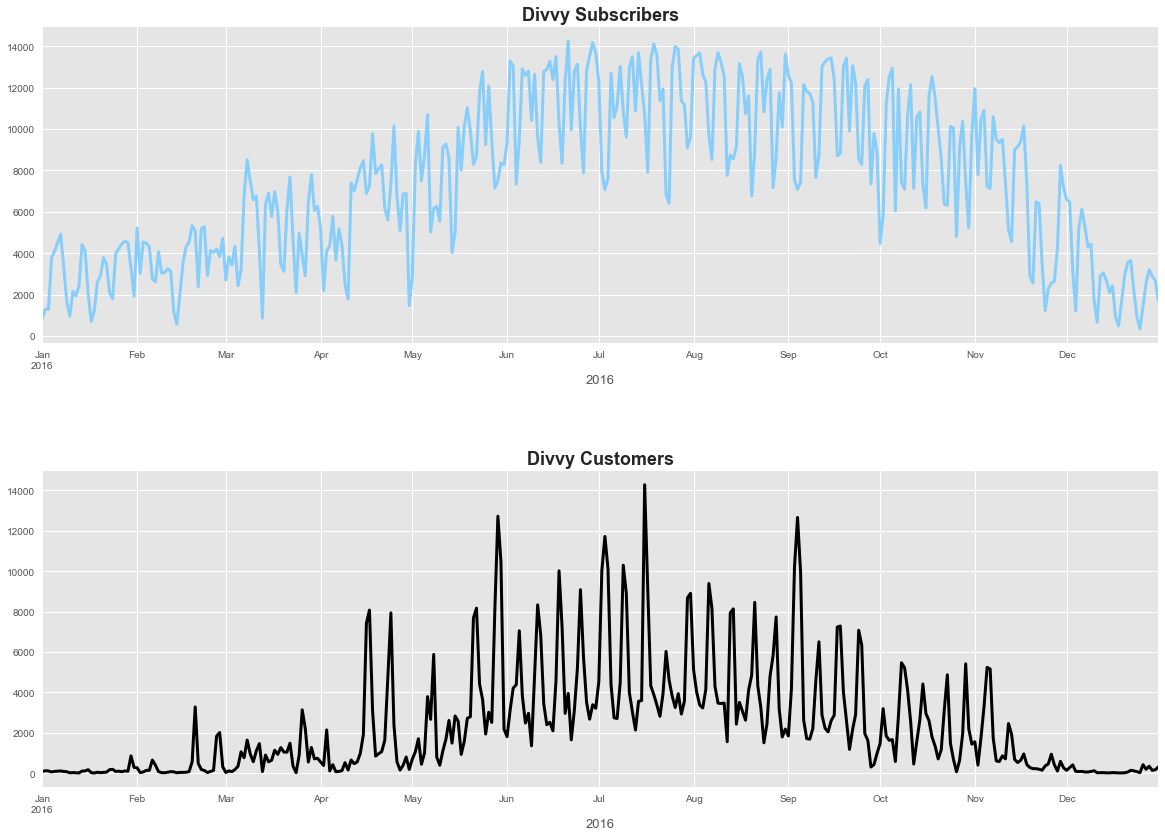

In [62]:
rides2 = rides[['Subscriber', 'Customer']]; rides2
fig, ax = plt.subplots(2, figsize=(20, 14))
plt.rcParams['lines.linewidth'] = 3
fig.subplots_adjust(hspace=0.4)
rides2.iloc[:, 0].plot(ax=ax[0], color='#87CEFA')
rides2.iloc[:, 1].plot(ax=ax[1], color='#000000');
ax[0].set_xlabel('2016', y=-1.04, fontsize=13)
ax[1].set_xlabel('2016', fontsize=13)
#ax[0].set_ylim([0, 3000])
#ax[1].set_ylim([0, 3000])
#for axi in ax:
#    axi.set_xticklabels(['January', 'February', 'March', 'April', 'May',
#                         'June', 'July', 'August', 'September','October',
#                         'November', 'December'], fontsize=13)
#for axi in ax:
#    axi.set_yticklabels(['2,000', '4,000', '6,000', '8,000', '10,000',
#                         '12,000', '14,000'], fontsize=13)
ax[0].set_title('Divvy Subscribers', fontsize=18, fontweight='bold')
ax[1].set_title('Divvy Customers', fontsize=18, fontweight='bold');
fig.savefig('Divvy_images/usage_trends_2016.png', bbox_inches='tight')

### Top days for Subscriber rides

In [63]:
#The day of the week with Monday=0, Sunday=6
mem = rides.sort_values('Subscriber', ascending=False)
mem['day'] = mem.index.weekday
print('Subscriber Top Ten \n{0}\n'
      .format(mem.sort_index(by='Subscriber', ascending=[False]).head(10)))
print('Subscriber Bottom Ten \n{0}'
      .format(mem.sort_index(by='Subscriber', ascending=[True]).head(10)))

Subscriber Top Ten 
user_type   Customer  Dependent  Subscriber  day
date                                            
2016-06-21    3946.0        NaN     14268.0    1
2016-06-29    3388.0        NaN     14171.0    2
2016-07-19    3882.0        1.0     14112.0    1
2016-07-26    3251.0        NaN     13994.0    1
2016-07-27    3938.0        2.0     13859.0    2
2016-08-23    3238.0        NaN     13712.0    1
2016-08-09    3466.0        1.0     13695.0    1
2016-07-14    3559.0        NaN     13691.0    3
2016-06-30    3213.0        NaN     13686.0    3
2016-08-03    3375.0        NaN     13681.0    2

Subscriber Bottom Ten 
user_type   Customer  Dependent  Subscriber  day
date                                            
2016-12-25      25.0        NaN       339.0    6
2016-12-18      14.0        NaN       492.0    6
2016-02-14      21.0        NaN       568.0    6
2016-12-11      18.0        NaN       669.0    6
2016-01-17      28.0        NaN       702.0    6
2016-01-01      84.0     

### Top days for Customer rides

In [64]:
#The day of the week with Monday=0, Sunday=6
cus = rides.sort_values('Customer', ascending=False)
cus['day'] = cus.index.weekday
print('Customer Top Ten \n{0}\n'
      .format(cus.sort_index(by='Customer', ascending=[False]).head(10)))
print('Customer Bottom Ten \n{0}'
      .format(cus.sort_index(by='Customer', ascending=[True]).head(10)))

Customer Top Ten 
user_type   Customer  Dependent  Subscriber  day
date                                            
2016-07-16   14281.0        NaN     10708.0    5
2016-05-29   12722.0        NaN      7518.0    6
2016-09-04   12660.0        NaN      7087.0    6
2016-07-03   11719.0        NaN      7073.0    6
2016-05-30   10448.0        NaN      8370.0    0
2016-07-09   10297.0        NaN     10857.0    5
2016-09-03   10190.0        NaN      7540.0    5
2016-07-04   10134.0        NaN      7611.0    0
2016-07-02   10034.0        NaN      7963.0    5
2016-06-18   10017.0        NaN     10260.0    5

Customer Bottom Ten 
user_type   Customer  Dependent  Subscriber  day
date                                            
2016-01-18       9.0        NaN      1224.0    0
2016-01-13      11.0        NaN      2429.0    2
2016-12-19      13.0        NaN      1696.0    0
2016-12-15      13.0        NaN      2106.0    3
2016-12-18      14.0        NaN       492.0    6
2016-12-11      18.0        N

**Customer top ten was dominated by weekend days and two Mondays which were national holidays**
**The bottom ten occurred during the bleak winter months and interesting enough included the Valentine's Day holiday.**

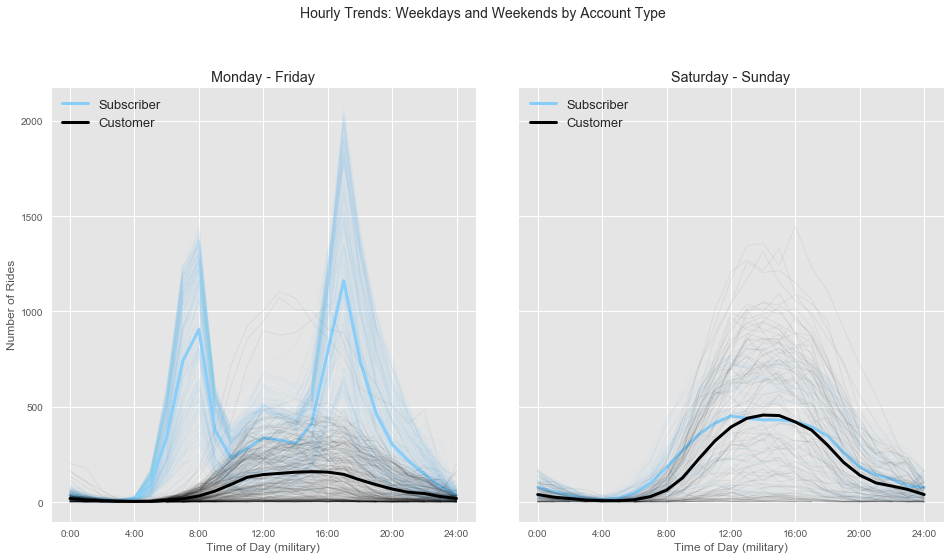

In [65]:
ind = pd.DatetimeIndex(divvy.date); ind.dayofweek
divvy['weekend'] = (ind.dayofweek > 4)
hourly = divvy.pivot_table('trip_id', aggfunc='count',
                           index=['date'], columns=['user_type', 'weekend', 'hour'])
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
fmt = plt.FuncFormatter(lambda x, *args: '{0}:00'.format(int(x)))
color_cycle = plt.rcParams['axes.color_cycle'] = ['#87CEFA', '#000000']

for weekend in (False, True):
    axi = ax[int(weekend)]
    for i, col in enumerate(['Subscriber', 'Customer']):
        vals = hourly[col][weekend].values
        vals = np.hstack([vals, vals[:, :1]])
        #values transformed plotted at slim linewidth
        axi.plot(range(25), vals.T, #alpha set to reduce transparency
                 color=color_cycle[i], lw=1, alpha=0.05)
        #mean (ignoring NaNs) of the values plotted with larger linewidth
        axi.plot(range(25), np.nanmean(vals, 0),
                 color=color_cycle[i], lw=3, label=col)
    axi.xaxis.set_major_locator(plt.MultipleLocator(4))
    axi.xaxis.set_major_formatter(fmt)
    #axi.set_ylim(0, 1700); axi.set_xlim(0, 24)
    axi.set_title('Saturday - Sunday' if weekend else 'Monday - Friday')
    axi.legend(loc='upper left', prop={'size':13})
    axi.set_xlabel('Time of Day (military)')
ax[0].set_ylabel('Number of Rides')
fig.suptitle('Hourly Trends: Weekdays and Weekends by Account Type', size=14, y=1.02);
fig.savefig('Divvy_images/hourly_trend.png', bbox_inches='tight')

> **Weekday:**
- **Weekday ridership peaks for members around the times a rider is likely to be heading to work or when returning home.** 
- **Casual ridership slowly rises in the morning and then remains relatively flat until eight p.m.**

> **Weekend:**
- **Weekend ridership follows a similar basic normal distribution throughout the day for each type of user.**

In [66]:
#divvy.month.value_counts().index.tolist()
#divvy.month.value_counts().keys()
divvy.month.value_counts().sort_index()

1      92839
2     118120
3     185954
4     231635
5     363319
6     477873
7     518093
8     484524
9     439194
10    350194
11    240408
12     93230
Name: month, dtype: int64

In [67]:
#The day of the week with Monday=0, Sunday=6
m = pd.DataFrame(divvy.month.value_counts().sort_values(ascending=False))
m = m.rename(columns={'month':'count'});
n = pd.DataFrame(divvy.month.value_counts()/divvy.month.value_counts().sum())
n = n*100; n = n.rename(columns={'month':'% of total'})
o = pd.DataFrame(n.sort_index().pct_change()*100)
o = o.rename(columns={'% of total':'pct change'})
months = {'month': ['index zero', 'January', 'February', 'March', 'April', 'May', 'June',
                    'July', 'August', 'September','October', 'November', 'December']}
months = pd.DataFrame(months, columns = months)

In [68]:
month_breakout = pd.concat([months, m, n, o], axis=1);
print(month_breakout[1:])
print
print('Total rides {0}\n'.format(divvy.month.value_counts().sum()))

        month     count  % of total  pct change
1     January   92839.0    2.582173         NaN
2    February  118120.0    3.285325   27.231013
3       March  185954.0    5.172022   57.428039
4       April  231635.0    6.442568   24.565753
5         May  363319.0   10.105154   56.849785
6        June  477873.0   13.291296   31.529868
7        July  518093.0   14.409953    8.416462
8      August  484524.0   13.476283   -6.479339
9   September  439194.0   12.215500   -9.355574
10    October  350194.0    9.740103  -20.264393
11   November  240408.0    6.686576  -31.350052
12   December   93230.0    2.593048  -61.220093

Total rides 3595383



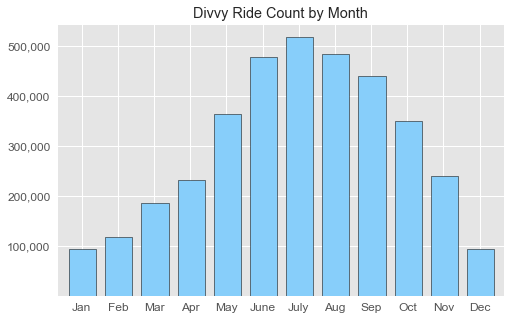

In [69]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
            'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.yticks([100000, 200000, 300000, 400000, 500000],
           ['100,000', '200,000', '300,000','400,000',
            '500,000'], fontsize=12)
plt.xlim([.33, 12.67])
pd.Series.hist(divvy.month, bins=np.arange(14)-0.35,
               width=0.75, color='#87CEFA', edgecolor='#000000')
plt.title("Divvy Ride Count by Month");

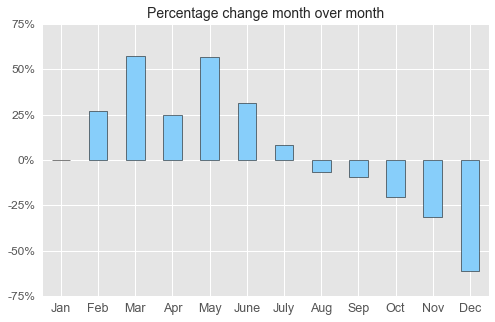

In [70]:
fig, ax = plt.subplots(figsize=(8, 5))
o['pct change'].plot(kind='bar', edgecolor="#000000");
plt.xticks(fontsize=12.5, rotation=0)
group_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May',
                'June', 'July', 'Aug', 'Sep', 'Oct',
                'Nov', 'Dec']
ax.set_xticklabels(group_labels)
plt.yticks([75, 50, 25, 0, -25, -50, -75],
           ['75%', '50%', '25%', '0%', '-25%',
            '-50%', '-75%'], fontsize=12)
plt.title('Percentage change month over month', fontsize=14)
fig.savefig('Divvy_images/percentage_change_by_month.png', bbox_inches='tight');

### Divvy Rides by broken out by User Type and Month

In [71]:
divvy_subscribers = divvy[divvy['user_type'] != 'Customer']
divvy_customers = divvy[divvy['user_type'] != 'Subscriber']

In [72]:
months = {'2016': ['-', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']}
months = pd.DataFrame(months, columns=months);

In [73]:
m = pd.DataFrame(divvy_subscribers.month.value_counts())
m = m.rename(columns={'month':'Subscriber Rides'})
c = pd.DataFrame(divvy_customers.month.value_counts())
c = c.rename(columns={'month':'Customer Rides'})
total = pd.DataFrame(divvy.month.value_counts().sort_index());
total = total.rename(columns={'month':'Total Rides'})
x = pd.concat([months, m, c, total], axis=1)

In [74]:
x = x.set_index('2016'); x = x.drop(['-'])

In [75]:
print(x)

      Subscriber Rides  Customer Rides  Total Rides
2016                                               
Jan            89373.0          3466.0      92839.0
Feb           106845.0         11275.0     118120.0
Mar           158682.0         27272.0     185954.0
Apr           182243.0         49392.0     231635.0
May           259808.0        103511.0     363319.0
Jun           349964.0        127909.0     477873.0
Jul           344377.0        173732.0     518093.0
Aug           348736.0        135795.0     484524.0
Sep           322335.0        116862.0     439194.0
Oct           278166.0         72035.0     350194.0
Nov           206731.0         33683.0     240408.0
Dec            89649.0          3582.0      93230.0


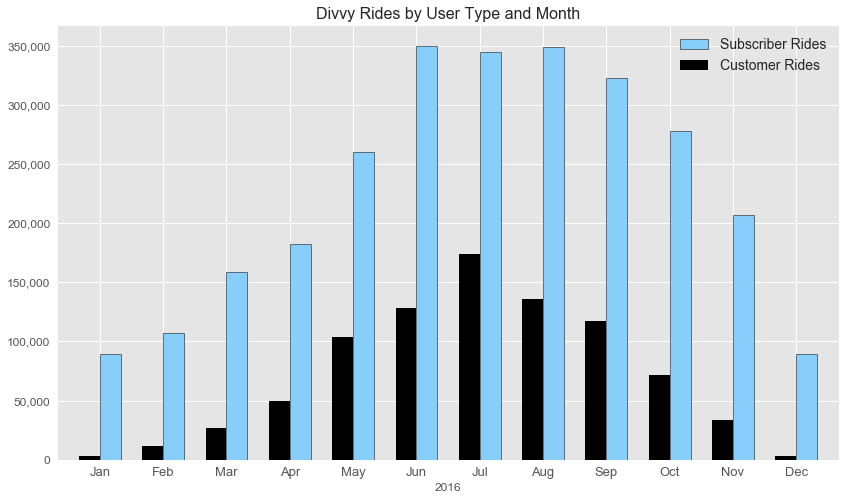

In [76]:
fig, ax = plt.subplots(figsize=(14, 8), sharex=True, sharey=True)
ax2 = sharex=ax

x['Subscriber Rides'].plot(kind='bar', color='#87CEFA',
                           edgecolor="000000", ax=ax,
                           position=0, width=0.33);
x['Customer Rides'].plot(kind='bar', color='#000000',
                           ax=ax2, position=1, width=0.33)
plt.xlim([-.67, 11.67])
plt.xticks(fontsize=13, rotation='horizontal')
plt.yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000], 
          ['0', '50,000', '100,000', '150,000', '200,000', '250,000',
           '300,000', '350,000'],fontsize=12)
plt.title('Divvy Rides by User Type and Month', size=16)
plt.legend(fontsize=14, loc='best');
fig.savefig('Divvy_images/breakout_by_month.png', bbox_inches='tight')

# Weather
**Explore the relationship between the weather and ridership** 

> NOAA Key:
- TAVG - Average Temperature
- TMAX - Maximum temperature
- TMIN - Minimum temperature
- PRCP - Precipitation
- AWND - Average wind speed
- SNOW - Snowfall
- WSF2 - Fastest 2-minute wind speed
- WSF5 - Fastest 5-second wind speed
- WDF2 - Direction of fastest 2-minute wind
- WDF5 - Direction of fastest 5-second wind
- WT01 - Fog, ice fog, or freezing fog (may include heavy fog)
- WT02 - Heavy fog or heaving freezing fog (not always distinguished from fog)
- WT03 - Thunder
- WT04 - Ice pellets, sleet, snow pellets, or small hail
- WT05 - Hail (may include small hail)
- WT06 - Glaze or rime 
- WT08 - Smoke or haze 
- WT09 - Blowing or drifting snow

In [77]:
chi_weather = pd.read_csv('Divvy_data/Chicago_Ohare_WU_NOAA.csv',
                         index_col='DATE', parse_dates=True)

In [78]:
chi_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2016-01-01 to 2016-12-31
Data columns (total 29 columns):
STATION           366 non-null object
STATION_NAME      366 non-null object
ELEVATION         366 non-null float64
LATITUDE          366 non-null float64
LONGITUDE         366 non-null float64
PRCP              366 non-null float64
SNOW              366 non-null float64
TAVG              366 non-null int64
TMAX              366 non-null int64
TMIN              366 non-null int64
AWND              366 non-null float64
WDF2              366 non-null int64
WDF5              366 non-null int64
WSF2              366 non-null float64
WSF5              366 non-null float64
WT09              366 non-null int64
WT01              366 non-null int64
WT06              366 non-null int64
WT05              366 non-null int64
WT02              366 non-null int64
WT04              366 non-null int64
WT08              366 non-null int64
WT03              366 non-null int64
high De

In [79]:
#Memory usage does not include memory consumed by elements
# that are not components of the array if deep=False
print('Total bytes: {0} and Total MB: {1}\n'
      .format(chi_weather.memory_usage(deep=True).sum(),
              int(chi_weather.memory_usage(deep=True).sum()/1048576)))
print(chi_weather.memory_usage(deep=True))

Total bytes: 136152 and Total MB: 0

Index              2928
STATION           22692
STATION_NAME      31476
ELEVATION          2928
LATITUDE           2928
LONGITUDE          2928
PRCP               2928
SNOW               2928
TAVG               2928
TMAX               2928
TMIN               2928
AWND               2928
WDF2               2928
WDF5               2928
WSF2               2928
WSF5               2928
WT09               2928
WT01               2928
WT06               2928
WT05               2928
WT02               2928
WT04               2928
WT08               2928
WT03               2928
high Dew Point     2928
avg Dew Point      2928
low Dew Point      2928
high Humidity      2928
avg Humidity       2928
low Humidity       2928
dtype: int64


In [80]:
chi_weather._data

BlockManager
Items: Index([u'STATION', u'STATION_NAME', u'ELEVATION', u'LATITUDE', u'LONGITUDE',
       u'PRCP', u'SNOW', u'TAVG', u'TMAX', u'TMIN', u'AWND', u'WDF2', u'WDF5',
       u'WSF2', u'WSF5', u'WT09', u'WT01', u'WT06', u'WT05', u'WT02', u'WT04',
       u'WT08', u'WT03', u'high Dew Point', u'avg Dew Point', u'low Dew Point',
       u'high Humidity', u'avg Humidity', u'low Humidity'],
      dtype='object')
Axis 1: DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name=u'DATE', length=366, freq=None)
FloatBlock: [2, 3, 4, 5, 6, 10, 13, 14], 8 x 366, dtype: float64
IntBlock: [7, 8, 9, 11, 12, 15, 16, 17, 18, 1

In [81]:
chi_weather.columns

Index([u'STATION', u'STATION_NAME', u'ELEVATION', u'LATITUDE', u'LONGITUDE',
       u'PRCP', u'SNOW', u'TAVG', u'TMAX', u'TMIN', u'AWND', u'WDF2', u'WDF5',
       u'WSF2', u'WSF5', u'WT09', u'WT01', u'WT06', u'WT05', u'WT02', u'WT04',
       u'WT08', u'WT03', u'high Dew Point', u'avg Dew Point', u'low Dew Point',
       u'high Humidity', u'avg Humidity', u'low Humidity'],
      dtype='object')

### Rename the columns for ease of typing

In [82]:
chi_weather = chi_weather.rename(columns={'DATE':'date', 'STATION':'station',
                                          'STATION_NAME':'station_name',
                                          'ELEVATION':'elevation', 'LATITUDE':'latitude',
                                          'LONGITUDE': 'longitude', 'TAVG':'average_temp',
                                          'TMAX':'max_temp', 'TMIN':'min_temp',
                                          'PRCP':'precipitation', 'AWND':'average_wind_speed',
                                          'SNOW':'snowfall', 'WSF2':'wsf2', 'WSF5':'wsf5',
                                          'WDF2':'wdf2', 'WDF5':'wdf5', 'WT01':'fog',
                                          'WT02':'heavy_fog', 'WT03': 'thunder',
                                          'WT04':'hail/sleet', 'WT05':'hail',
                                          'WT06':'glaze/rime', 'WT08':'haze',
                                          'WT09': 'blowing_snow',
                                          'high Dew Point': 'high_dew_point',
                                          'avg Dew Point':'average_dew_point',
                                          'low Dew Point':'low_dew_point',
                                          'high Humidity':'high_humidity',
                                          'avg Humidity':'average_humidity',
                                          'low Humidity':'low_humidity'})

In [83]:
chi_weather.columns

Index([u'station', u'station_name', u'elevation', u'latitude', u'longitude',
       u'precipitation', u'snowfall', u'average_temp', u'max_temp',
       u'min_temp', u'average_wind_speed', u'wdf2', u'wdf5', u'wsf2', u'wsf5',
       u'blowing_snow', u'fog', u'glaze/rime', u'hail', u'heavy_fog',
       u'hail/sleet', u'haze', u'thunder', u'high_dew_point',
       u'average_dew_point', u'low_dew_point', u'high_humidity',
       u'average_humidity', u'low_humidity'],
      dtype='object')

In [84]:
chi_weather.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name=u'DATE', length=366, freq=None)

### Check for null values

In [85]:
complete_forecast = chi_weather.notnull().sum() * 100.0/chi_weather.shape[0]
complete_forecast = complete_forecast.round(2); complete_forecast.sort()
print("Percentage complete for each column: \n{0}"
      .format(complete_forecast))

Percentage complete for each column: 
station               100.0
high_humidity         100.0
low_dew_point         100.0
average_dew_point     100.0
high_dew_point        100.0
thunder               100.0
haze                  100.0
hail/sleet            100.0
heavy_fog             100.0
hail                  100.0
glaze/rime            100.0
fog                   100.0
blowing_snow          100.0
average_humidity      100.0
wsf5                  100.0
wdf5                  100.0
wdf2                  100.0
average_wind_speed    100.0
min_temp              100.0
max_temp              100.0
average_temp          100.0
snowfall              100.0
precipitation         100.0
longitude             100.0
latitude              100.0
elevation             100.0
station_name          100.0
wsf2                  100.0
low_humidity          100.0
dtype: float64


### All weather data is derived from measurements at O'Hare International Airport
**Will therefore dispense with any airport-related columns having constant values**

In [86]:
chi_weather.drop(['station', 'station_name', 'elevation', 'latitude', 'longitude'],
                 axis=1, inplace=True)

In [87]:
chi_weather.head(2)

,precipitation,snowfall,average_temp,max_temp,min_temp,average_wind_speed,wdf2,wdf5,wsf2,wsf5,...,heavy_fog,hail/sleet,haze,thunder,high_dew_point,average_dew_point,low_dew_point,high_humidity,average_humidity,low_humidity
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.0,0.0,23,31,19,14.3,260,250,21.9,28.0,...,0,0,0,0,22,18,12,77,73,68
2016-01-02,0.0,0.0,27,32,20,12.1,260,230,23.0,32.0,...,0,0,0,0,23,19,16,84,74,63


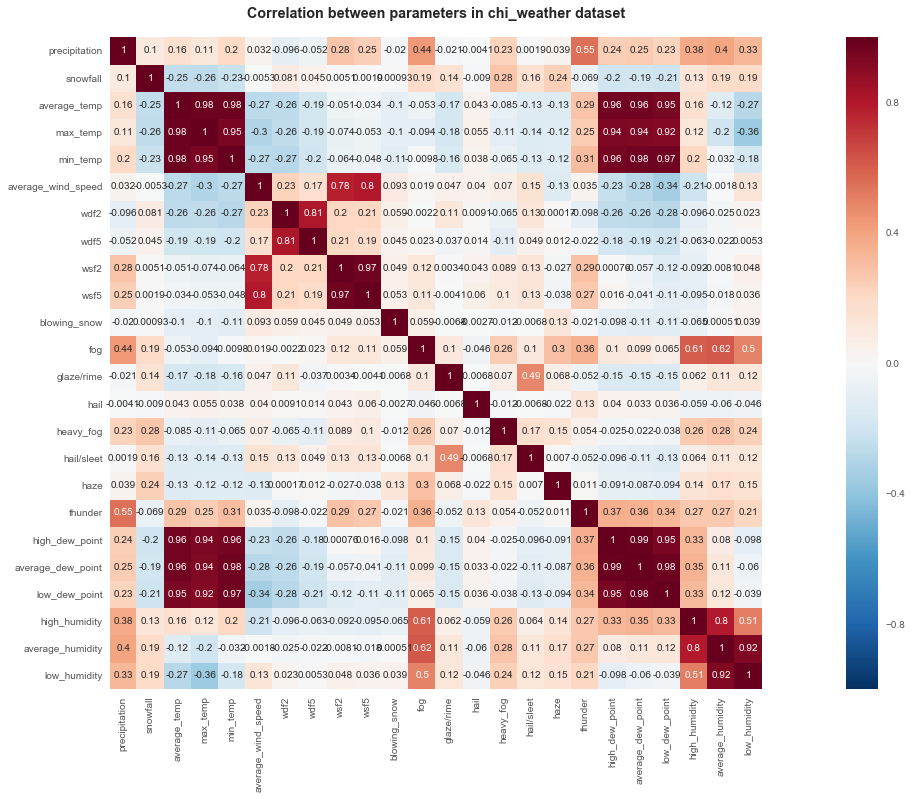

In [88]:
correlation = chi_weather.corr()
plt.figure(figsize=(30, 12))
sns.heatmap(correlation, square=True, annot=True)
plt.title('Correlation between parameters in chi_weather dataset',
          fontsize='x-large', fontweight='bold', y=1.02);

**Before any consideration of modeling, might wish to dispense with highly correlated, very similar columns such as high or low temperature and just keep average temperature.**

### The range of each series in the weather dataframe

**Some of the columns are just binaries so the range will only appear as a 1, or possibly a 0 if said weather event never occurred.**

In [89]:
def data_range(series):
    return series.max() - series.min()
data_range(chi_weather)

precipitation           1.6
snowfall                6.4
average_temp           86.0
max_temp               86.0
min_temp               88.0
average_wind_speed     23.5
wdf2                  350.0
wdf5                  350.0
wsf2                   36.9
wsf5                   51.0
blowing_snow            1.0
fog                     1.0
glaze/rime              1.0
hail                    1.0
heavy_fog               1.0
hail/sleet              1.0
haze                    1.0
thunder                 1.0
high_dew_point         83.0
average_dew_point      81.0
low_dew_point          86.0
high_humidity          43.0
average_humidity       57.0
low_humidity           71.0
dtype: float64

**Could consider dropping either max/min columns or average columns of certain weather events due to tight ranges and high correlation**

In [90]:
by_date = divvy.groupby(['date', 'user_type'])['trip_id'].count()   
by_date.name = 'count'    
by_date = by_date.reset_index('user_type').join(chi_weather)
by_date['weekend'] = (by_date.index.dayofweek >= 5)

In [91]:
by_date.head(4)

,user_type,count,precipitation,snowfall,average_temp,max_temp,min_temp,average_wind_speed,wdf2,wdf5,...,hail/sleet,haze,thunder,high_dew_point,average_dew_point,low_dew_point,high_humidity,average_humidity,low_humidity,weekend
2016-01-01,Customer,84,0.0,0.0,23,31,19,14.3,260,250,...,0,0,0,22,18,12,77,73,68,False
2016-01-01,Subscriber,851,0.0,0.0,23,31,19,14.3,260,250,...,0,0,0,22,18,12,77,73,68,False
2016-01-02,Customer,121,0.0,0.0,27,32,20,12.1,260,230,...,0,0,0,23,19,16,84,74,63,True
2016-01-02,Subscriber,1300,0.0,0.0,27,32,20,12.1,260,230,...,0,0,0,23,19,16,84,74,63,True


### Temperature

In [92]:
print('The mean of the daily average temperature for 2016: {:.2f}\n'
      .format(chi_weather.average_temp.mean()))
print('The average daily temperature range for 2016 - max of {0} and min of {1}.'
      .format(chi_weather.max_temp.max(), chi_weather.min_temp.min()))

The mean of the daily average temperature for 2016: 52.51

The average daily temperature range for 2016 - max of 93 and min of -13.


In [93]:
print('All temperature data --> degrees Fahrenheit.\n')
hot = chi_weather[chi_weather.max_temp >= 90]
print('The number of days where the \
high temperature hit 90 degrees or above: {0}\n'.format(len(hot)))
chilly = chi_weather[chi_weather.max_temp <= 40]
print('The number of days with the \
high temperature capped at 40 degrees or less: {0}\n'.format(len(chilly)))
why_people_move_away = chi_weather[chi_weather.min_temp <= 30]
print('The number of days where the \
low temperature dipped to 30 degrees or below: {0}\n'.format(len(why_people_move_away)))

All temperature data --> degrees Fahrenheit.

The number of days where the high temperature hit 90 degrees or above: 16

The number of days with the high temperature capped at 40 degrees or less: 79

The number of days where the low temperature dipped to 30 degrees or below: 95



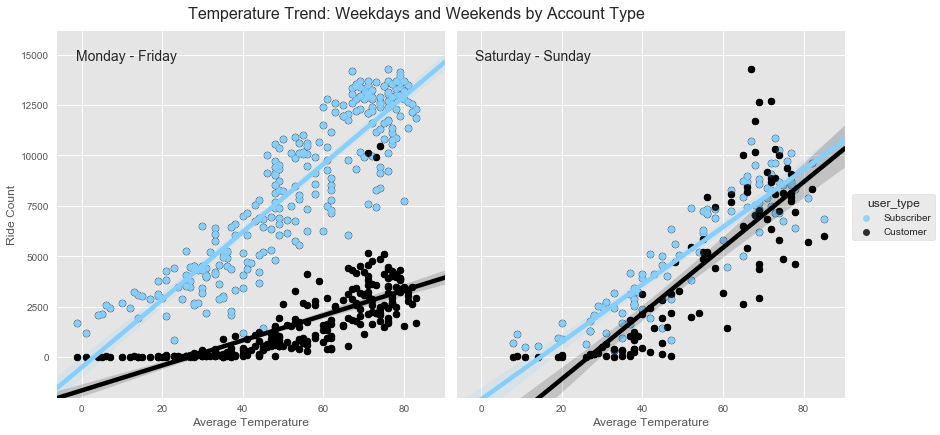

In [94]:
c = dict(Customer='#000000', Subscriber='#87CEFA', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='user_type',
                  palette=c, hue_order=["Subscriber", "Customer"], size=6)
g.map(plt.scatter, "average_temp", "count", edgecolor="black")
g.map(sns.regplot, "average_temp", "count")
g.add_legend(frameon=True)
#g.axes[0,0].set_xlim(-15,)
#g.axes[0,1].set_xlim(-15,)
g.axes[0,0].set_ylim(-2000,)
g.axes[0,1].set_ylim(-2000,)
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Temperature Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Average Temperature')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Divvy_images/temp_trend.png', bbox_inches='tight')

### Precipitation

In [95]:
total_prec = chi_weather.precipitation.sum()
print('Total precipitation for 2016 was {0} inches'.format(total_prec))

Total precipitation for 2016 was 35.97 inches


In [96]:
year=366; avg_precip = total_prec/year; round(avg_precip, 3)

0.098

In [97]:
wet = chi_weather.precipitation.value_counts(); wet.head()

0.00    236
0.02     14
0.01     13
0.10      7
0.03      5
Name: precipitation, dtype: int64

In [98]:
print('Percentage of days in 2016 without any recorded precipitation: {:.2f}%'
      .format(wet[0]/year*100))

Percentage of days in 2016 without any recorded precipitation: 64.48%


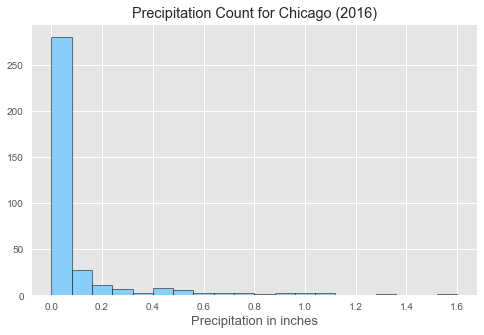

In [99]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(chi_weather.precipitation, bins=20, color='#87CEFA', edgecolor='#000000')
plt.xlabel('Precipitation in inches', fontsize=13)
plt.title('Precipitation Count for Chicago (2016)');

In [100]:
rainy = chi_weather[chi_weather.precipitation >= 1.0];
print('Days with an inch or more of recorded precipitation: {0}'
      .format(len(rainy)))
v_rainy = chi_weather[chi_weather.precipitation >= 2.0]
print('Days with two or more inches of recorded precipitation: {0}'
      .format(len(v_rainy)))

Days with an inch or more of recorded precipitation: 6
Days with two or more inches of recorded precipitation: 0


**Not enough precipitation in aggregate or precipitation events of significance to plot a linear regression of value.**

### Snow
**Since Divvy runs year-round (as opposed to MN Nice Ride, we should take a peek at the snow data to see if there was any impact on ridership.**

In [101]:
total_snowfall = chi_weather.snowfall.sum()
print('Total snow for 2016 was {0} inches'.format(total_snowfall))

Total snow for 2016 was 33.2 inches


In [102]:
winter_wonderland = chi_weather.snowfall.value_counts()
winter_wonderland.head()

0.0    341
0.1      5
1.7      3
0.4      3
0.8      2
Name: snowfall, dtype: int64

In [103]:
print('Percentage of days in 2016 without any recorded snowfall: {:.2f}%'
      .format(winter_wonderland[0]/year*100))

Percentage of days in 2016 without any recorded snowfall: 93.17%


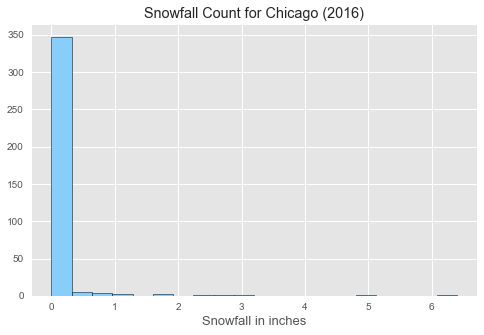

In [104]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(chi_weather.snowfall, bins=20, color='#87CEFA', edgecolor='#000000')
plt.xlabel('Snowfall in inches', fontsize=13)
plt.title('Snowfall Count for Chicago (2016)');

In [105]:
snowy = chi_weather[chi_weather.snowfall >= 1.0];
print('Days with an inch or more of recorded snowfall: {0}'
      .format(len(snowy)))
snowier = chi_weather[chi_weather.snowfall >= 2.0]
print('Days with two or more inches of recorded snowfall: {0}'
      .format(len(snowier)))
v_snowy = chi_weather[chi_weather.snowfall >= 3.0]
print('Days with three or more inches of recorded snowfall: {0}'
      .format(len(v_snowy)))

Days with an inch or more of recorded snowfall: 10
Days with two or more inches of recorded snowfall: 5
Days with three or more inches of recorded snowfall: 3


**Not enough snow in aggregate or precipitation events of significance to plot a linear regression of value.**

### Humidity
> - Relative humidity measures the actual amount of moisture in the air as a percentage of the maximum amount of moisture the air can hold.
- Humidity % - Absolute humidity is the percentage of water vapor actually present in the air.
- The relative humidity typically ranges from 44% (comfortable) to 91% (very humid) over the course of the year, rarely dropping below 25% (dry) and reaching as high as 100% (very humid).
- The air is driest around May 3, at which time the relative humidity drops below 53% (mildly humid) three days out of four; it is most humid around August 13, exceeding 84% (humid) three days out of four.<br>
https://weatherspark.com/averages/30851/Chicago-Illinois-United-States

In [106]:
print('The mean of the daily average humidity: {:.2f}\n'
      .format(chi_weather.average_humidity.mean()))
print('The humidity range for the 2016 season - max of {0} and min of {1}.'
      .format(chi_weather.average_humidity.max(), chi_weather.average_humidity.min()))

The mean of the daily average humidity: 69.90

The humidity range for the 2016 season - max of 95 and min of 38.


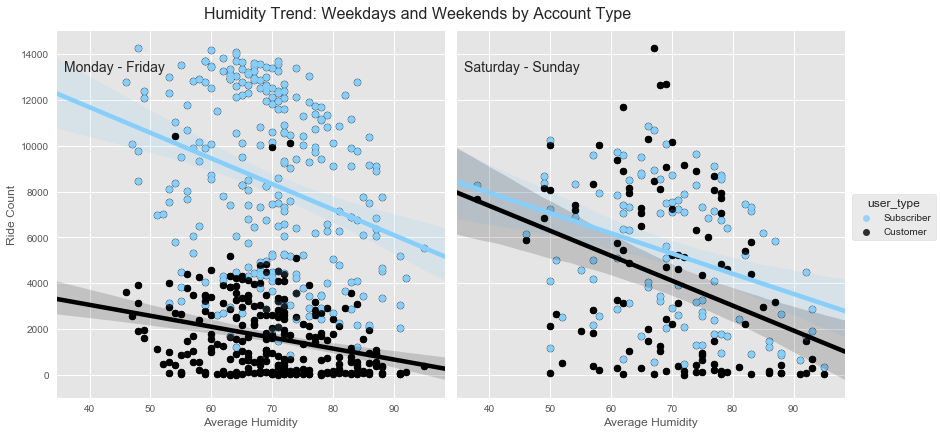

In [107]:
c = dict(Customer='#000000', Subscriber='#87CEFA', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='user_type',
                  palette=c, hue_order=["Subscriber", "Customer"], size=6)
g.map(plt.scatter, 'average_humidity', "count", edgecolor="black")
g.map(sns.regplot, 'average_humidity', 'count')
g.add_legend(frameon=True);
g.axes[0, 0].set_ylim(-1000, 15000)
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.02, 0.92, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.02, 0.92, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Humidity Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Average Humidity')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Divvy_images/humidity.png', bbox_inches='tight')

### Dew Point
> - Dew Point: the atmospheric temperature (varying according to pressure and humidity) below which water droplets begin to condense and dew can form.
- Dew point is often a better measure of how comfortable a person will find the weather than relative humidity because it more directly relates to whether perspiration will evaporate from the skin, thereby cooling the body. Lower dew points feel drier and higher dew points feel more humid.
- Over the course of a year, the dew point typically varies from 10°F (dry) to 67°F (muggy) and is rarely below -9°F (dry) or above 74°F (very muggy).
- There are two periods in the year that are most comfortable: The first is between May 8 and July 4 and the second is between August 25 and October 7. The air feels neither too dry nor too muggy during these periods.

In [108]:
print('The mean of the daily average dew point of the 2016 season: {:.2f}\n'
      .format(chi_weather.average_dew_point.mean()))
print('The dew point range for the 2016 season - max of {0} and min of {1}.'
      .format(chi_weather.average_dew_point.max(), chi_weather.average_dew_point.min()))

The mean of the daily average dew point of the 2016 season: 42.24

The dew point range for the 2016 season - max of 73 and min of -8.


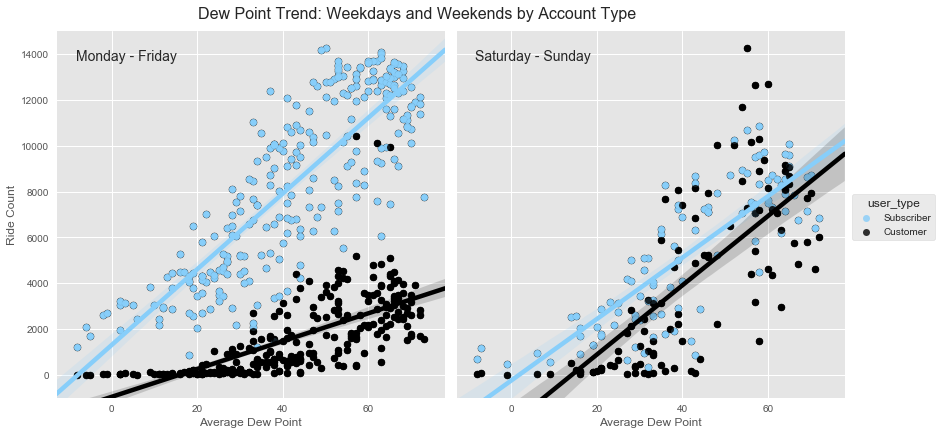

In [109]:
c = dict(Customer='#000000', Subscriber='#87CEFA', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='user_type',
                  palette=c, hue_order=["Subscriber", "Customer"], size=6)
g.map(plt.scatter, 'average_dew_point', 'count', edgecolor="black")
g.map(sns.regplot, 'average_dew_point', 'count')
g.add_legend(frameon=True);
g.axes[0, 0].set_ylim(-1000, 15000)
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Dew Point Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Average Dew Point')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Divvy_images/dew_point.png', bbox_inches='tight')

### Wind

In [110]:
print('The average fastest 2 min wind speed in 2016: {:.2f}\n'
      .format(chi_weather.wsf2.mean()))
print('The fastest 2 min wind speed in 2016 - max of {0} and min of {1}.'
      .format(chi_weather.wsf2.max(), chi_weather.wsf2.min()))

The average fastest 2 min wind speed in 2016: 20.16

The fastest 2 min wind speed in 2016 - max of 45.0 and min of 8.1.


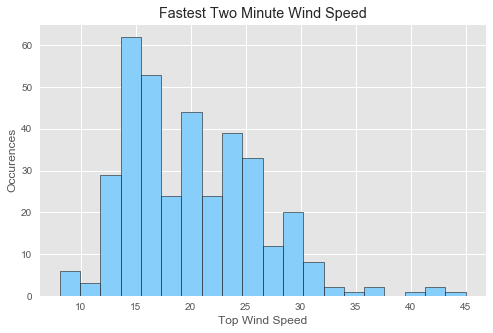

In [111]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(chi_weather.wsf2, bins=20, color='#87CEFA', edgecolor='#000000')
plt.ylabel('Occurences')
plt.xlabel('Top Wind Speed');
plt.title('Fastest Two Minute Wind Speed');

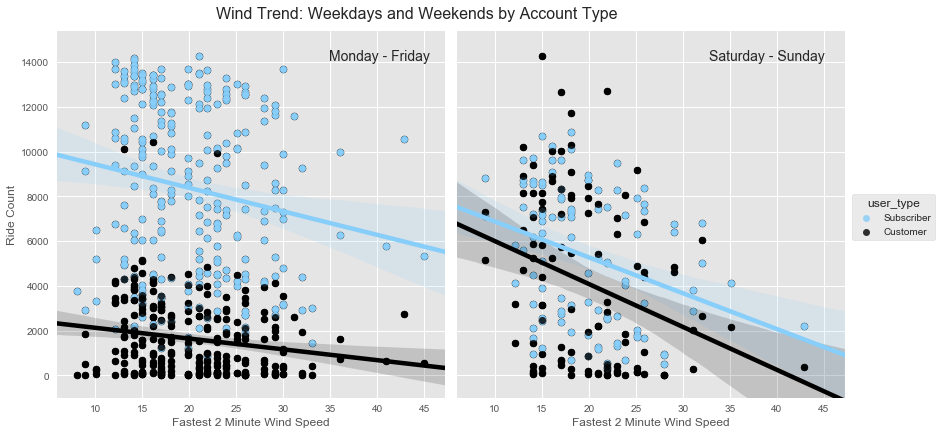

In [112]:
c = dict(Customer='#000000', Subscriber='#87CEFA', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='user_type',
                  palette=c, hue_order=["Subscriber", "Customer"], size=6)
g.map(plt.scatter, 'wsf2', 'count', edgecolor="black")
g.map(sns.regplot, 'wsf2', 'count')
g.add_legend(frameon=True);
g.axes[0,0].set_ylim(-1000,)
g.axes[0,1].set_ylim(-1000,)
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.70, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.65, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Wind Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Fastest 2 Minute Wind Speed')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Divvy_images/wind.png', bbox_inches='tight')

### Wind Direction
> - http://tornado.sfsu.edu/geosciences/classes/m430/Wind/WindDirection.html
- http://climate.umn.edu/snow_fence/components/winddirectionanddegreeswithouttable3.htm
- https://en.wikipedia.org/wiki/Wind_direction
- Wind direction is usually reported in cardinal directions or in azimuth degrees.<br>For example, a wind coming from the south is given as 180 degrees; one from the east is 90 degrees.

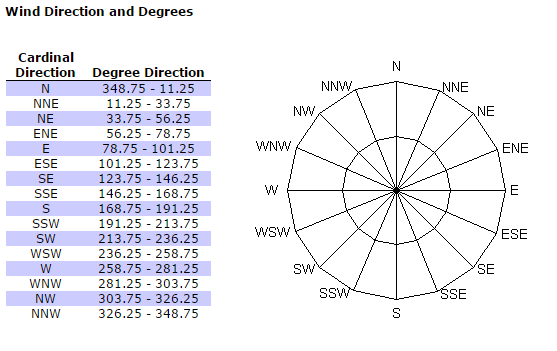

In [113]:
from IPython.display import Image
wind = Image('Divvy_images/chart.png'); wind

In [114]:
d = chi_weather.wdf2.value_counts(); d.sort(ascending=False); d.head(10)

190    25
100    22
260    21
330    20
200    17
40     17
300    16
20     16
320    15
50     14
Name: wdf2, dtype: int64

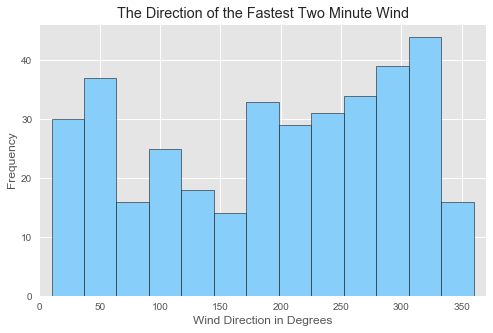

In [115]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(chi_weather.wdf2, bins=13, edgecolor='#000000')
plt.xlim(0, 370)
plt.ylabel('Frequency')
plt.xlabel('Wind Direction in Degrees')
plt.title('The Direction of the Fastest Two Minute Wind');